In [ ]:
import tensorflow as tf

#Get the GPU device name
device_name = tf.test.gpu_device_name()

#Device name should look like the following:
if device_name == '/device:GPU:0' :
    print('Found GPU at: {}'.format(device_name))
else :
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch
 
#if there is a GPU available
if torch.cuda.is_available():
 
  #pytorch should use the GPU
  device=torch.device("cuda")
 
  print('There are %d GPUs available.'%torch.cuda.device_count())
 
  print('We will use the GPU: ', torch.cuda.get_device_name(0))
 
#if not use CPU instead
else:
  print('No GPU available. Using CPU instead.')  
  device=torch.device("cpu")

There are 1 GPUs available.
We will use the GPU:  Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers

     |████████████████████████████████| 1.9MB 8.3MB/s 
     |████████████████████████████████| 890kB 49.0MB/s 
     |████████████████████████████████| 3.2MB 51.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=aadb2e7d766e6e1394eadb34be56616eda4bebc4b24d5fb977f99c430762e314
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import os
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/AUTH_PROF_BERT DataSet/bert_train.csv") 

In [ ]:
ss = df['sentence'].tolist()

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()



ss = [" ".join([stemmer.stem(word) for word in sentence.split(" ")]) for sentence in ss]

ss = [" ".join([lemmatizer.lemmatize(word) for word in sentence.split(" ")]) for sentence in ss]

In [ ]:
df['sentence'] = ss

In [ ]:
df = df[~df['label'].isnull()]
df[['label']] = df[['label']].astype(int)


In [ ]:
df.tail()

,ID,label,sentence
272695,fff1359e0dc1eba31a10120bf16834b7.csv,0,hey studio q nzh said yes print abus look legit
272696,fff1359e0dc1eba31a10120bf16834b7.csv,0,god let asswip post self piti piec mother day
272697,fff1359e0dc1eba31a10120bf16834b7.csv,0,week pinch stalk co old timer day
272698,fff1359e0dc1eba31a10120bf16834b7.csv,0,stori relev co timelin know say legit post nz ...
272699,fff1359e0dc1eba31a10120bf16834b7.csv,0,rate system launch


In [ ]:
df.sentence

0                                                     tweet
1                                           watch avail feb
2         complet set box batman minifig find want fig b...
3                                          mayb come arrang
4              heard numer toyworld number despit warn damn
                                ...                        
272695      hey studio q nzh said yes print abus look legit
272696        god let asswip post self piti piec mother day
272697                    week pinch stalk co old timer day
272698    stori relev co timelin know say legit post nz ...
272699                                   rate system launch
Name: sentence, Length: 272700, dtype: object

In [ ]:
# Get the lists of sentences and their labels.
sentences = df.sentence.values
labels = df.label.values

In [ ]:
type(sentences)

numpy.ndarray

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
# Print the original sentence.
print(' Original: ', sentences[1])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[1]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[1])))

 Original:  watch avail feb
Tokenized:  ['watch', 'avail', 'feb']
Token IDs:  [3422, 24608, 13114]


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features  .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  tweet
Token IDs: [101, 1056, 28394, 2102, 102]


In [ ]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  50


In [ ]:
MAX_LEN = 64

In [ ]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length.
# I've chosen 64 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 50...
MAX_LEN = 64

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")



Padding/truncating all sentences to 64 values...

Padding token: "[PAD]", ID: 0


In [ ]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [ ]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

In [ ]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test 
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  7,670.    Elapsed: 0:00:14.
  Batch    80  of  7,670.    Elapsed: 0:00:28.
  Batch   120  of  7,670.    Elapsed: 0:00:42.
  Batch   160  of  7,670.    Elapsed: 0:00:56.
  Batch   200  of  7,670.    Elapsed: 0:01:10.
  Batch   240  of  7,670.    Elapsed: 0:01:24.
  Batch   280  of  7,670.    Elapsed: 0:01:38.
  Batch   320  of  7,670.    Elapsed: 0:01:52.
  Batch   360  of  7,670.    Elapsed: 0:02:06.
  Batch   400  of  7,670.    Elapsed: 0:02:20.
  Batch   440  of  7,670.    Elapsed: 0:02:34.
  Batch   480  of  7,670.    Elapsed: 0:02:49.
  Batch   520  of  7,670.    Elapsed: 0:03:03.
  Batch   560  of  7,670.    Elapsed: 0:03:17.
  Batch   600  of  7,670.    Elapsed: 0:03:31.
  Batch   640  of  7,670.    Elapsed: 0:03:45.
  Batch   680  of  7,670.    Elapsed: 0:03:59.
  Batch   720  of  7,670.    Elapsed: 0:04:13.
  Batch   760  of  7,670.    Elapsed: 0:04:27.
  Batch   800  of  7,670.    Elapsed: 0:04:41.
  Batch   840  of

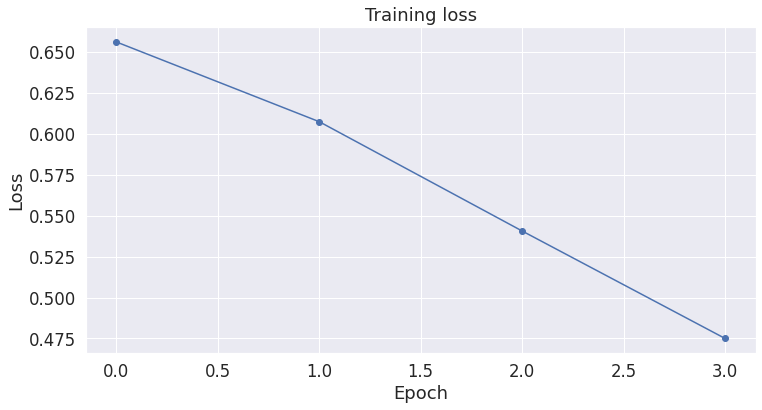

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [ ]:
import os
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/AUTH_PROF_BERT DataSet/bert_test.csv") 

In [ ]:
dss = df['sentence'].tolist()


dss = [" ".join([stemmer.stem(word) for word in sentence.split(" ")]) for sentence in dss]
dss = [" ".join([lemmatizer.lemmatize(word) for word in sentence.split(" ")]) for sentence in dss]

df['sentence'] = dss

In [ ]:
df.tail()

,ID,label,sentence
189995,fff5a17288a8ab173e493c90bf4b39a4.csv,NaN,hair hardest
189996,fff5a17288a8ab173e493c90bf4b39a4.csv,NaN,saw seal wild tell happi
189997,fff5a17288a8ab173e493c90bf4b39a4.csv,NaN,note up get readi way bed asleep omg
189998,fff5a17288a8ab173e493c90bf4b39a4.csv,NaN,happi
189999,fff5a17288a8ab173e493c90bf4b39a4.csv,NaN,but thank hope year marvel


In [ ]:
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 
# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 190,000



In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 190,000 test sentences...
    DONE.


In [ ]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

In [ ]:
len(flat_predictions)

190000

In [ ]:
from collections import Counter 
  
def most_frequent(List): 
    occurence_count = Counter(List) 
    return occurence_count.most_common(1)[0][0]

In [ ]:
chunks = [flat_predictions[x:x+100] for x in range(0, len(flat_predictions),100)]
gender=[]

In [ ]:
for i in chunks:
    gender.append(most_frequent(i))

In [ ]:
len(gender)

1900

In [ ]:
import os
import pandas as pd

btest = pd.read_csv("/content/drive/MyDrive/AUTH_PROF_BERT DataSet/bert_test_labels.csv") 

In [ ]:
btest['bert_gender'] = gender

In [ ]:
btest.loc[btest.gender == 'male', 'gender'] = 1
btest.loc[btest.gender == 'female', 'gender'] = 0

In [ ]:
btest.head()

,ID,gender,buffer,bert_gender
0,100c885443c4d2a32075e10cbca9a27e.csv,0,100c885443c4d2a32075e10cbca9a27e,0
1,1017647e21e7e73d900e1dfacbf95a0f.csv,0,1017647e21e7e73d900e1dfacbf95a0f,1
2,1023e1e534622e28d29dfdc0ee45cdac.csv,1,1023e1e534622e28d29dfdc0ee45cdac,1
3,10283d7f37d33b063e3734b740f5229d.csv,0,10283d7f37d33b063e3734b740f5229d,0
4,1069f66c9d5862f860277d32780ac459.csv,0,1069f66c9d5862f860277d32780ac459,0


In [ ]:
from sklearn.metrics import accuracy_score

y_true = btest['gender'].tolist()
y_pred = btest['bert_gender'].tolist()

print('The accuracy from the Bert classifier is,',accuracy_score(y_true, y_pred))

The accuracy from the Bert classifier is, 0.7705263157894737


In [ ]:
from sklearn import metrics
print("Some basic stastistical measures for this model are")
print(metrics.classification_report(y_true, y_pred))
 
print("The Confusion Matrix is")
print(metrics.confusion_matrix(y_true, y_pred))

Some basic stastistical measures for this model are
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       940
           1       0.80      0.73      0.76       960

    accuracy                           0.77      1900
   macro avg       0.77      0.77      0.77      1900
weighted avg       0.77      0.77      0.77      1900

The Confusion Matrix is
[[765 175]
 [261 699]]
